# The following notebooks addresses a practical optimization problem related to resource allocation in manufacturing industry.



Consider a factory that produces four distinct products, with the daily production amount of the first, second, third, and fourth products denoted by x₁, x₂, x₃, and x₄, respectively. The primary objective is to determine the optimal daily production amount of each product to maximize profits, subject to the following constraints:

Constraint 1: The profit per unit of product is 20, 12, 40, and 25 for the first, second, third, and fourth product, respectively.

Constraint 2: The total number of units produced per day cannot exceed fifty due to labor limitations.

Constraint 3: For each unit of the first product, three units of raw material A are consumed. The second product requires two units of A and one unit of raw material B, while the third product necessitates one unit of A and two units of B. Finally, the fourth product requires three units of B.

Constraint 4:Due to transportation and storage limitations, the factory can consume no more than one hundred units of raw material A and ninety units of B per day.

# The mathematical model can be defined as follows:

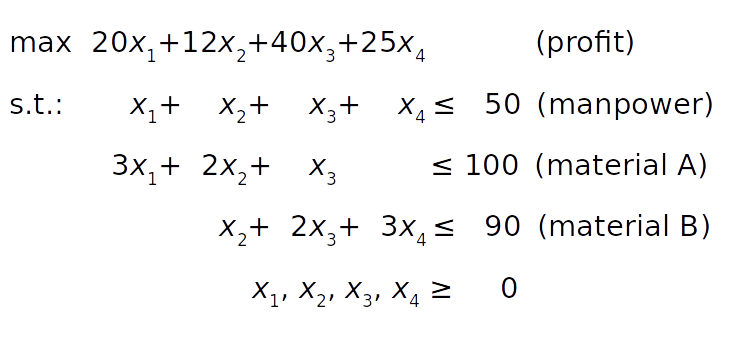

# Using SCIPY library

In [1]:
# pip install -U scipy
# pip install -U "pulp==2.1"

In [2]:
import scipy
scipy.__version__

'1.10.1'

In [3]:
from scipy.optimize import linprog

In [4]:
obj = [-20, -12, -40, -25]
lhs_ineq = [[1, 1, 1, 1],  # Manpower
             [3, 2, 1, 0],  # Material A
             [0, 1, 2, 3]]  # Material B
rhs_ineq = [ 50,  # Manpower
            100,  # Material A
            90]  # Material B

# opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,method="revised simplex")
opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,method="highs")
opt

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -1900.0
              x: [ 5.000e+00  0.000e+00  4.500e+01  0.000e+00]
            nit: 4
          lower:  residual: [ 5.000e+00  0.000e+00  4.500e+01  0.000e+00]
                 marginals: [ 0.000e+00  1.800e+01  0.000e+00  2.500e+01]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  4.000e+01  0.000e+00]
                 marginals: [-2.000e+01 -0.000e+00 -1.000e+01]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

# Using PuLP for Linear Programming and Mixed Integer LP

In [5]:
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable

In [6]:
# Define the model
model = LpProblem(name="resource-allocation", sense=LpMaximize)

# Define the decision variables
x = {i: LpVariable(name=f"x{i}", lowBound=0) for i in range(1, 5)}

# Add constraints
model += (lpSum(x.values()) <= 50, "manpower")
model += (3 * x[1] + 2 * x[2] + x[3] <= 100, "material_a")
model += (x[2] + 2 * x[3] + 3 * x[4] <= 90, "material_b")

# Set the objective
model += 20 * x[1] + 12 * x[2] + 40 * x[3] + 25 * x[4]

# Solve the optimization problem
status = model.solve()

# Get the results
print(f"status: {model.status}, {LpStatus[model.status]}")
print('---------------------------------------------')
print(f"objective: {model.objective.value()}")
print('---------------------------------------------')
for var in x.values():
    print(f"{var.name}: {var.value()}")
print('---------------------------------------------')
for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")
print('---------------------------------------------')    

status: 1, Optimal
---------------------------------------------
objective: 1900.0
---------------------------------------------
x1: 5.0
x2: 0.0
x3: 45.0
x4: 0.0
---------------------------------------------
manpower: 0.0
material_a: -40.0
material_b: 0.0
---------------------------------------------


The most profitable solution is to produce 5.0 units of the first product and 45.0 units of the third product per day.

## Suppose the factory can’t produce the first and third products in parallel due to a machinery issue. What’s the most profitable solution in this case?

Now we have another logical constraint: if x₁ is positive, then x₃ must be zero and vice versa. This is where binary decision variables are very useful. we’ll use two binary decision variables, y₁ and y₃, that’ll denote if the first or third products are generated at all.

In [7]:
model = LpProblem(name="resource-allocation", sense=LpMaximize)

# Define the decision variables
x = {i: LpVariable(name=f"x{i}", lowBound=0) for i in range(1, 5)}
y = {i: LpVariable(name=f"y{i}", cat="Binary") for i in (1, 3)}

# Add constraints
model += (lpSum(x.values()) <= 50, "manpower")
model += (3 * x[1] + 2 * x[2] + x[3] <= 100, "material_a")
model += (x[2] + 2 * x[3] + 3 * x[4] <= 90, "material_b")

M = 100
model += (x[1] <= y[1] * M, "x1_constraint")
model += (x[3] <= y[3] * M, "x3_constraint")
model += (y[1] + y[3] <= 1, "y_constraint")

# Set objective
model += 20 * x[1] + 12 * x[2] + 40 * x[3] + 25 * x[4]

# Solve the optimization problem
status = model.solve()

print(f"status: {model.status}, {LpStatus[model.status]}")
print('---------------------------------------------')

print(f"objective: {model.objective.value()}")
print('---------------------------------------------')

for var in model.variables():
    print(f"{var.name}: {var.value()}")
print('---------------------------------------------')

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")
print('---------------------------------------------')
    

status: 1, Optimal
---------------------------------------------
objective: 1800.0
---------------------------------------------
x1: 0.0
x2: 0.0
x3: 45.0
x4: 0.0
y1: 0.0
y3: 1.0
---------------------------------------------
manpower: -5.0
material_a: -55.0
material_b: 0.0
x1_constraint: 0.0
x3_constraint: -55.0
y_constraint: 0.0
---------------------------------------------


It turns out that the optimal approach is to exclude the first product and to produce only the third one.

 # Using GUROBIPY for linear programming

For solving the following simple optimization model:
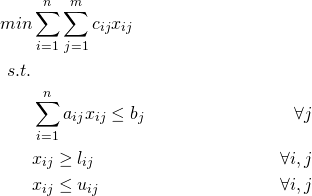

In [8]:
# pip install gurobipy

Defining the input parameters

In [9]:
import random
n = 10
m = 5
set_I = range(1, n+1)
set_J = range(1, m+1)
c = {(i,j): random.normalvariate(0,1) for i in set_I for j in set_J}
a = {(i,j): random.normalvariate(0,5) for i in set_I for j in set_J}
l = {(i,j): random.randint(0,10) for i in set_I for j in set_J}
u = {(i,j): random.randint(10,20) for i in set_I for j in set_J}
b = {j: random.randint(0,30) for j in set_J}

In [10]:
import gurobipy as grb
opt_model = grb.Model(name="MIP Model")

Restricted license - for non-production use only - expires 2024-10-28


In [11]:
# if x is Continuous
x_vars  ={(i,j):opt_model.addVar(vtype=grb.GRB.CONTINUOUS, 
                        lb=l[i,j], 
                        ub= u[i,j],
                        name="x_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}
# if x is Binary
x_vars  = {(i,j):opt_model.addVar(vtype=grb.GRB.BINARY,
                        name="x_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}
# if x is Integer
x_vars  ={(i,j):opt_model.addVar(vtype=grb.GRB.INTEGER,
                        lb=l[i,j], 
                        ub= u[i,j],
                        name="x_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}

In [12]:
# <= constraints
constraints = {j : 
opt_model.addConstr(
        lhs=grb.quicksum(a[i,j] * x_vars[i,j] for i in set_I),
        sense=grb.GRB.LESS_EQUAL,
        rhs=b[j], 
        name="constraint_{0}".format(j))
    for j in set_J}
# >= constraints
constraints = {j : 
opt_model.addConstr(
        lhs=grb.quicksum(a[i,j] *x_vars[i,j] for i in set_I),
        sense=grb.GRB.GREATER_EQUAL,
        rhs=b[j], 
        name="constraint_{0}".format(j))
    for j in set_J}
# == constraints
constraints = {j : 
opt_model.addConstr(
        lhs=grb.quicksum(a[i,j] * x_vars[i,j] for i in set_I),
        sense=grb.GRB.EQUAL,
        rhs=b[j], 
        name="constraint_{0}".format(j))
    for j in set_J}

C:\Users\VHTR_FC\AppData\Local\Temp/ipykernel_23484/732075724.py:2: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  constraints = {j :
C:\Users\VHTR_FC\AppData\Local\Temp/ipykernel_23484/732075724.py:10: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  constraints = {j :
C:\Users\VHTR_FC\AppData\Local\Temp/ipykernel_23484/732075724.py:18: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  constraints = {j :


In [13]:
objective = grb.quicksum(x_vars[i,j] * c[i,j] 
                         for i in set_I 
                         for j in set_J)

In [14]:
# for maximization
opt_model.ModelSense = grb.GRB.MAXIMIZE
# for minimization
opt_model.ModelSense = grb.GRB.MINIMIZE
opt_model.setObjective(objective)

In [15]:
opt_model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8400 CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads

Optimize a model with 15 rows, 150 columns and 150 nonzeros
Model fingerprint: 0x6267b8b0
Variable types: 50 continuous, 100 integer (50 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  Objective range  [6e-03, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [3e+00, 2e+01]
Presolve removed 2 rows and 100 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 6 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


# Using CPLEX for linear programming

In [16]:
# pip install cplex docplex

In [17]:
import docplex.mp.model as cpx
opt_model = cpx.Model(name="MIP Model")

In [25]:
# if x is Continuous
x_vars  = {(i,j): opt_model.continuous_var(lb=l[i,j], ub= u[i,j], name="x_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}
# if x is Binary
x_vars  ={(i,j): opt_model.binary_var(name="x_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}
# if x is Integer
x_vars  = {(i,j): opt_model.integer_var(lb=l[i,j], ub= u[i,j], name="x_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}

In [19]:
# <= constraints
constraints = {j : 
opt_model.add_constraint(
ct=opt_model.sum(a[i,j] * x_vars[i,j] for i in set_I) <= b[j],
ctname="constraint_{0}".format(j))
    for j in set_J}
# >= constraints
constraints = {j : 
opt_model.add_constraint(
ct=opt_model.sum(a[i,j] * x_vars[i,j] for i in set_I) >= b[j],
ctname="constraint_{0}".format(j))
    for j in set_J}
# == constraints
constraints = {j : 
opt_model.add_constraint(
ct=opt_model.sum(a[i,j] * x_vars[i,j] for i in set_I) == b[j],
ctname="constraint_{0}".format(j))
    for j in set_J}

In [20]:
objective = opt_model.sum(x_vars[i,j] * c[i,j] 
                          for i in set_I 
                          for j in set_J)

In [21]:
# for maximization
opt_model.maximize(objective)
# for minimization
opt_model.minimize(objective)

In [22]:
# solving with local cplex
opt_model.solve()